In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn import cross_validation, metrics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def fit_clf(X_train, y_train):
    clf = XGBClassifier(max_depth=4, base_score=0.005)
    cv = StratifiedKFold(y_train, n_folds=3, shuffle=True)
    y_pred_train = np.ones(y_train.shape[0])
    for i, (train, test) in enumerate(cv):
        y_pred_train[test] = clf.fit(X_train.iloc[train], y_train.iloc[train]).predict_proba(X_train.iloc[test])[:,1]
        print("fold {}, ROC AUC: {:.3f}".format(i, metrics.roc_auc_score(y_train.iloc[test], y_pred_train[test])))
    print(metrics.roc_auc_score(y_train, y_pred_train))

    clf.fit(X_train, y_train)
    y_pred_train = clf.predict_proba(X_train)[:,1]
    plt.figure()
    thresholds = np.linspace(0.01, 1.00, 100)
    mcc = np.array([metrics.matthews_corrcoef(y_train, y_pred_train>thr) for thr in thresholds])
    plt.plot(thresholds, mcc)
    best_threshold = thresholds[mcc.argmax()]
    print("MCC: %f" % mcc.max())
    
    return clf, best_threshold


def predict(clf, X_train, y_train, best_threshold, X_test, y_test):
    train_predictions = clf.predict(X_train)
    train_predprob = (clf.predict_proba(X_train)[:,1] > best_threshold).astype(int)
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, train_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, train_predprob))
    
    plt.figure()

    # Predict on testing data:
    test_predprob = (clf.predict_proba(X_test)[:,1] > best_threshold).astype(int)
    #results = test_results.merge(dtest[['ID','predprob']], on='ID')
    print('AUC Score (Test): %f' % metrics.roc_auc_score(y_test, test_predprob))
                
    feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return test_predprob


### 全列で学習してみる

fold 0, ROC AUC: 0.673
fold 1, ROC AUC: 0.722
fold 2, ROC AUC: 0.707
0.6989688077951142


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.268031


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9945
AUC Score (Train): 0.581788
AUC Score (Test): 0.584092


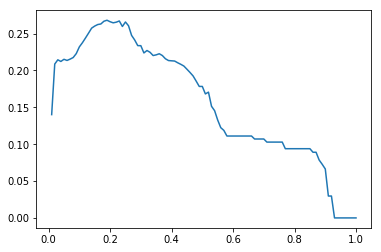

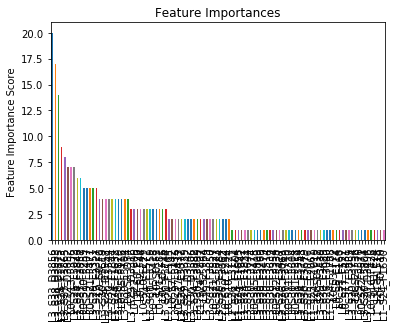

In [14]:
nrows = 200000
train_d = pd.read_csv('../input/train_date.csv',nrows=nrows)
train_n = pd.read_csv('../input/train_numeric.csv',nrows=nrows)
train_d = train_d.set_index('Id')
train_n = train_n.set_index('Id')

X_train = pd.concat([train_d, train_n.loc[:, train_n.columns != 'Response']], axis=1)
y_train = train_n['Response']

X_suc = X_train.loc[y_train==0,:]

X_train.fillna(X_suc.mean())

clf, best_threshold = fit_clf(X_train, y_train)

vali_d = pd.read_csv('../input/train_date.csv',skiprows=range(1,10001),nrows=10000)
vali_n = pd.read_csv('../input/train_numeric.csv',skiprows=range(1,10001),nrows=10000)
vali_d = vali_d.set_index('Id')
vali_n = vali_n.set_index('Id')
X_vali = pd.concat([vali_d, vali_n.loc[:, vali_n.columns != 'Response']], axis=1)
y_vali = vali_n['Response']

y_pred = predict(clf, X_train, y_train, best_threshold, X_vali, y_vali)

外れ値をNaNにする

In [23]:
nrows = 100000
#train_d = pd.read_csv('../input/train_date.csv',nrows=nrows)
train_n = pd.read_csv('../input/train_numeric.csv',nrows=nrows)
#train_d = train_d.set_index('Id')
train_n = train_n.set_index('Id')

#X_train = pd.concat([train_d, train_n.loc[:, train_n.columns != 'Response']], axis=1)
X = train_n.loc[:, train_n.columns != 'Response']
y = train_n['Response']

なにもしていない状態

fold 0, ROC AUC: 0.680
fold 1, ROC AUC: 0.650
fold 2, ROC AUC: 0.658
0.6623560999009586


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.384311


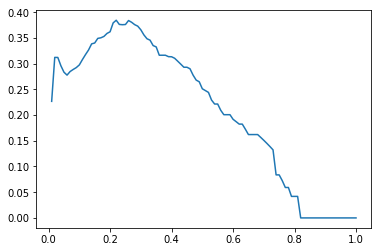

In [24]:
clf, best_threshold = fit_clf(X, y)

外れ値をNaNに書き換えた状態

In [11]:
X[3 < ((X-X.mean()) / X.std())] = np.NaN

C:\Users\tmiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\tmiya\Anaconda3\lib\site-packages\pandas\core\frame.py:3160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


In [7]:
X

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
Id,,,,,,,,,,,,,,,,,,,,,
4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,0.083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,-0.147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,-0.046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,-0.099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0.003,0.019,0.294,0.312,0.031,0.161,0.022,0.088,-0.005,-0.003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,-0.016,-0.041,-0.179,-0.179,-0.056,0.161,-0.007,-0.032,-0.082,0.163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


fold 0, ROC AUC: 0.664
fold 1, ROC AUC: 0.684
fold 2, ROC AUC: 0.643
0.6636547792163716


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.374667


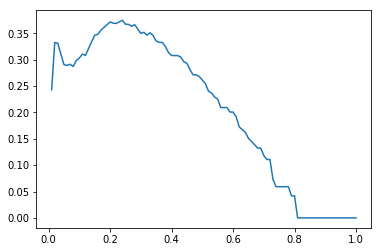

In [12]:
clf, best_threshold = fit_clf(X, y)

Text(0,0.5,'Feature Importance Score')

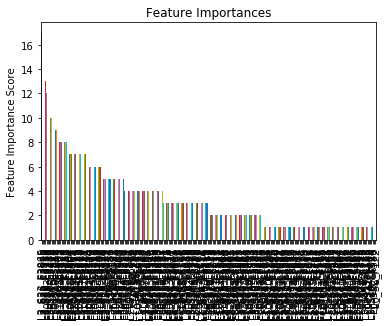

In [14]:
    feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [22]:
(6 < feat_imp).sum()

37

Nanをmeanで埋めてみる

fold 0, ROC AUC: 0.654
fold 1, ROC AUC: 0.669
fold 2, ROC AUC: 0.660
0.6614241249451817


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.360167


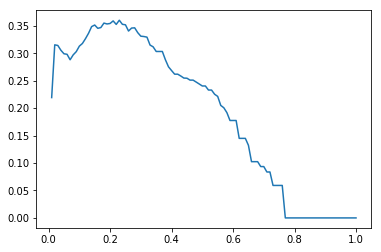

In [9]:
X = X.fillna(X.mean())
clf, best_threshold = fit_clf(X, y)

dupの特徴量を追加する

In [4]:
nrows = 100000
#train_d = pd.read_csv('../input/train_date.csv',nrows=nrows)
train_n = pd.read_csv('../input/train_numeric.csv',nrows=nrows)
#train_d = train_d.set_index('Id')
train_n = train_n.set_index('Id')

#X_train = pd.concat([train_d, train_n.loc[:, train_n.columns != 'Response']], axis=1)
X_train = train_n.loc[:, train_n.columns != 'Response']
y_train = train_n['Response']

In [6]:
X_suc = X_train.loc[y_train==0,:]
X_train = X_train.fillna(X_suc.mean())

In [7]:
for col in X_train.columns:
    X_train[col+'_dup'] = X_train[col].duplicated().values


fold 0, ROC AUC: 0.668
fold 1, ROC AUC: 0.659
fold 2, ROC AUC: 0.698
0.6740448730273062


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.276506


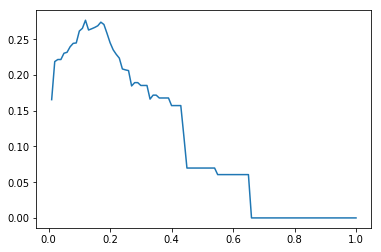

In [8]:

clf, best_threshold = fit_clf(X_train, y_train)


### nanの多い列を除いて学習してみる

C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.781624


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9952
AUC Score (Train): 0.942341
AUC Score (Test): 0.508374


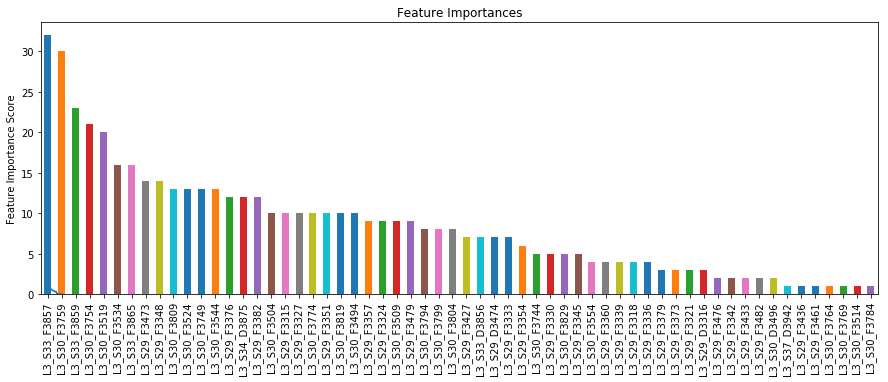

In [133]:
train_d = pd.read_csv('../input/train_date.csv',nrows=10000)
train_n = pd.read_csv('../input/train_numeric.csv',nrows=10000)

train_d_isnan = train_d.isna().astype(int)
train_n_isnan = train_n.isna().astype(int)
train_d_count_rate = (train_d.count() / len(train_d))
train_n_count_rate = (train_n.count() / len(train_n))
train_d_indices = np.where(0.8 < train_d_count_rate)[0]
train_n_indices = np.where(0.8 < train_n_count_rate)[0]

train_d = pd.read_csv('../input/train_date.csv',nrows=10000,usecols=train_d_indices)
train_n = pd.read_csv('../input/train_numeric.csv',nrows=10000,usecols=train_n_indices)

train_d = train_d.set_index('Id')
train_n = train_n.set_index('Id')

X_train = pd.concat([train_d, train_n.loc[:, train_n.columns != 'Response']], axis=1)
y_train = train_n['Response']

clf, best_threshold = fit_clf(X_train, y_train)

vali_d = pd.read_csv('../input/train_date.csv',skiprows=range(1,10001),nrows=10000,usecols=train_d_indices)
vali_n = pd.read_csv('../input/train_numeric.csv',skiprows=range(1,10001),nrows=10000,usecols=train_n_indices)
vali_d = vali_d.set_index('Id')
vali_n = vali_n.set_index('Id')
X_vali = pd.concat([vali_d, vali_n.loc[:, vali_n.columns != 'Response']], axis=1)
y_vali = vali_n['Response']

y_pred = predict(clf, X_train, y_train, best_threshold, X_vali, y_vali)

In [174]:
for i, (train, test) in enumerate(cv):
    print("%d" %i)
    y_train[train]

0
1
2


C:\Users\tmiya\Anaconda3\lib\site-packages\pandas\core\series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [36]:
y_vali.sum()

21

C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.995
AUC Score (Train): 0.966636
AUC Score (Test): 0.497992


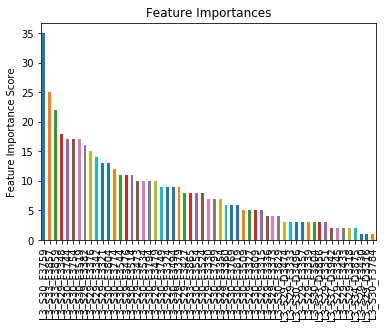

In [80]:
y_pred = predict(clf, X_train, y_train, best_threshold-0.02, X_vali, y_vali)

In [81]:
y_pred.sum()

20

### 全列で学習してみる

fold 0, ROC AUC: 0.643
fold 1, ROC AUC: 0.624
fold 2, ROC AUC: 0.673
0.6429681083326536


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.134914


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.996
AUC Score (Train): 0.838818
AUC Score (Test): 0.508022


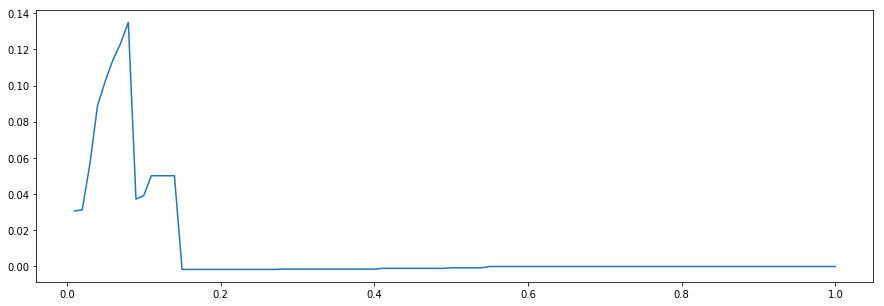

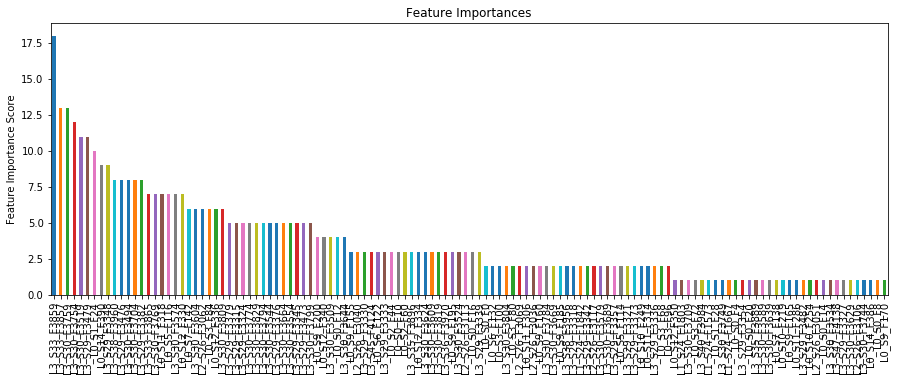

In [209]:
#train_d = pd.read_csv('../input/train_date.csv',nrows=10000)
train_n = pd.read_csv('../input/train_numeric.csv',nrows=10000)
#train_d = train_d.set_index('Id')
train_n = train_n.set_index('Id')

#X_train = pd.concat([train_d, train_n.loc[:, train_n.columns != 'Response']], axis=1)
X_train = train_n.loc[:, train_n.columns != 'Response']
y_train = train_n['Response']

clf, best_threshold = fit_clf(X_train, y_train)

#vali_d = pd.read_csv('../input/train_date.csv',skiprows=range(1,10001),nrows=10000)
vali_n = pd.read_csv('../input/train_numeric.csv',skiprows=range(1,10001),nrows=10000)
#vali_d = vali_d.set_index('Id')
vali_n = vali_n.set_index('Id')
#X_vali = pd.concat([vali_d, vali_n.loc[:, vali_n.columns != 'Response']], axis=1)
X_vali = vali_n.loc[:, vali_n.columns != 'Response']
y_vali = vali_n['Response']

y_pred = predict(clf, X_train, y_train, best_threshold, X_vali, y_vali)

### nanの多い列を除いて学習してみる

fold 0, ROC AUC: 0.654
fold 1, ROC AUC: 0.582
fold 2, ROC AUC: 0.603
0.6101763876849188


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.039127


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9955
AUC Score (Train): 0.829334
AUC Score (Test): 0.499899


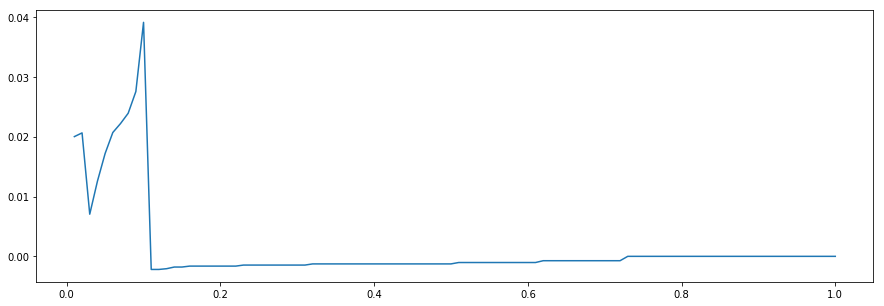

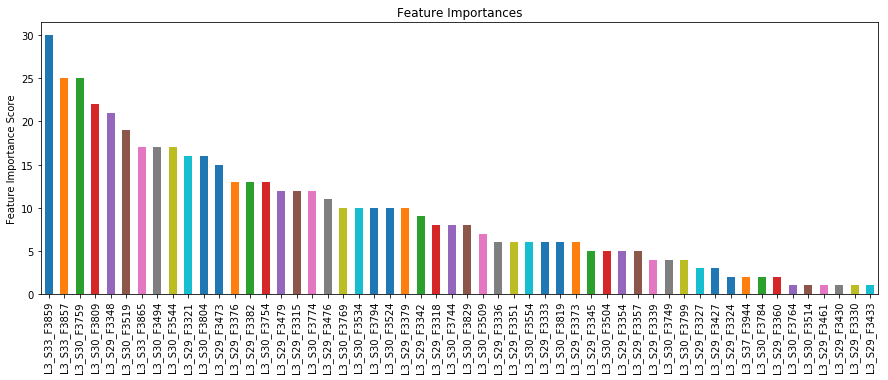

In [208]:
train_n = pd.read_csv('../input/train_numeric.csv',nrows=10000)

train_n_isnan = train_n.isna().astype(int)
train_n_count_rate = (train_n.count() / len(train_n))
train_n_indices = np.where(0.8 < train_n_count_rate)[0]

train_n = pd.read_csv('../input/train_numeric.csv',nrows=10000,usecols=train_n_indices)

train_n = train_n.set_index('Id')

X_train = train_n.loc[:, train_n.columns != 'Response']
y_train = train_n['Response']

clf, best_threshold = fit_clf(X_train, y_train)

vali_n = pd.read_csv('../input/train_numeric.csv',skiprows=range(1,10001),nrows=10000,usecols=train_n_indices)
vali_n = vali_n.set_index('Id')
X_vali = vali_n.loc[:, vali_n.columns != 'Response']
y_vali = vali_n['Response']

y_pred = predict(clf, X_train, y_train, best_threshold, X_vali, y_vali)

### xgboostの特徴量ランキングの高いものだけで学習してみる

In [303]:
nrows = 20000
train_n = pd.read_csv('../input/train_numeric.csv',nrows=nrows)

X_train = train_n.loc[:, train_n.columns != 'Response']
y_train = train_n['Response']
#clf = XGBClassifier(booster='dart', max_depth=3, base_score=0.005)
clf = XGBClassifier(base_score=0.005)
clf.fit(X_train, y_train)


XGBClassifier(base_score=0.005, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [304]:
train_n_indices = np.where(clf.feature_importances_>0.005)[0]
train_n_indices = np.append(train_n_indices, [len(train_n.columns)-1])

Text(0,0.5,'Feature Importance Score')

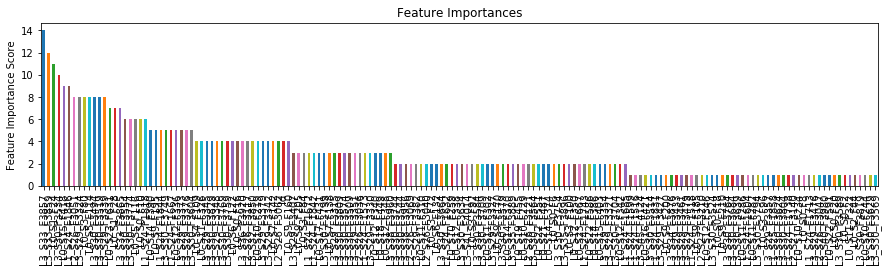

In [305]:
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

fold 0, ROC AUC: 0.679
fold 1, ROC AUC: 0.629
fold 2, ROC AUC: 0.603
0.6354659969210241


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.152489


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9947
AUC Score (Train): 0.669355
AUC Score (Test): 0.580419


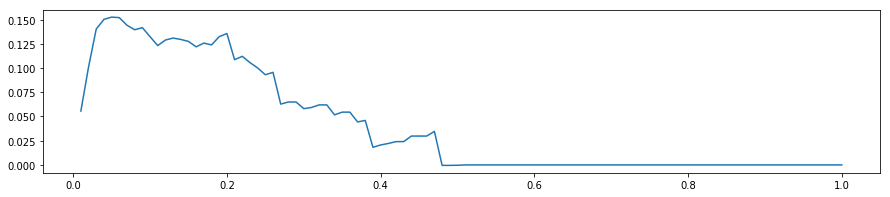

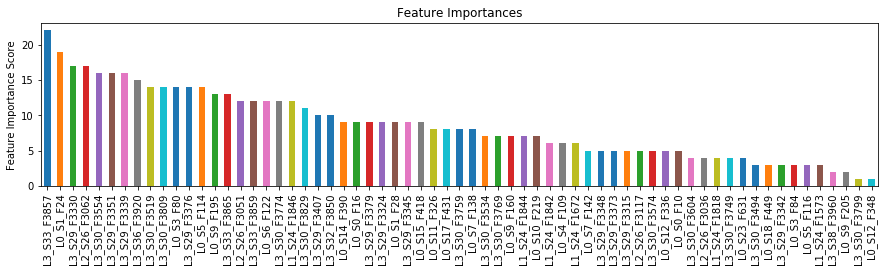

In [306]:
nrows = 50000
train_n = pd.read_csv('../input/train_numeric.csv',nrows=nrows,usecols=train_n_indices)

train_n = train_n.set_index('Id')

X_train = train_n.loc[:, train_n.columns != 'Response']
y_train = train_n['Response']

clf, best_threshold = fit_clf(X_train, y_train)

vali_n = pd.read_csv('../input/train_numeric.csv',skiprows=range(1,nrows+1),nrows=nrows,usecols=train_n_indices)
vali_n = vali_n.set_index('Id')
X_vali = vali_n.loc[:, vali_n.columns != 'Response']
y_vali = vali_n['Response']

y_pred = predict(clf, X_train, y_train, best_threshold, X_vali, y_vali)

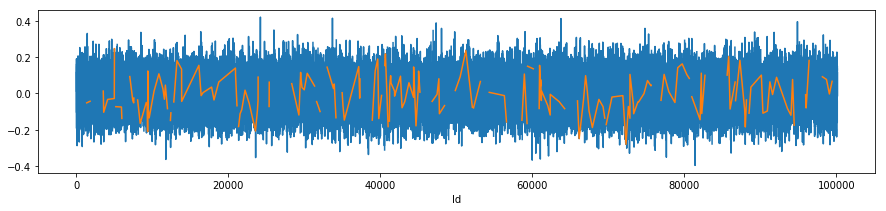

In [253]:
X_train.loc[:,"L3_S33_F3857"].plot()
X_train.loc[y_train==1,"L3_S33_F3857"].plot()

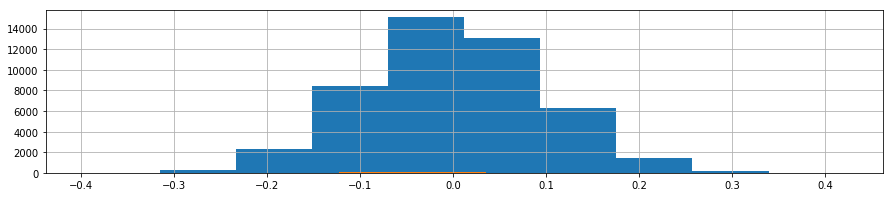

In [258]:
X_train.loc[:,"L3_S33_F3857"].hist()
X_train.loc[y_train==1,"L3_S33_F3857"].hist()

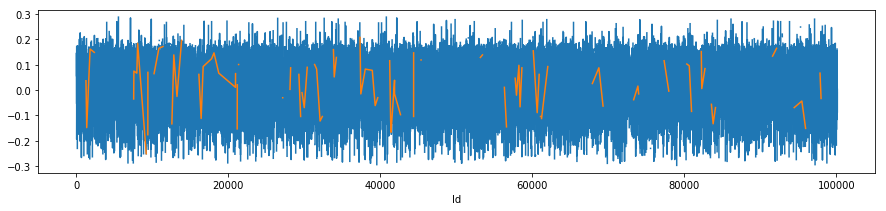

In [254]:
X_train.loc[:,"L0_S1_F24"].plot()
X_train.loc[y_train==1,"L0_S1_F24"].plot()

In [283]:
X_train.loc[:,"L3_S33_F3857"].rolling(100).mean().values

array([nan, nan, nan, ..., nan, nan, nan])

In [287]:
X_train.loc[y_train==1,"L3_S33_F3857"].isna().sum() / len(X_train.loc[y_train==1,"L3_S33_F3857"])

0.21033210332103322

In [288]:
X_train.loc[:,"L3_S33_F3857"].isna().sum() / len(X_train.loc[:,"L3_S33_F3857"])

0.06006

In [193]:
#sns.pairplot(X_train)
y_pred_train.max()

0.7540369

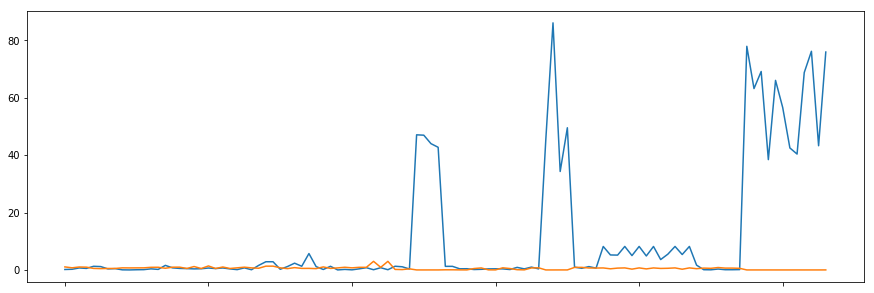

In [150]:
X_train.skew(axis=0).abs().plot()
(X_train.std(axis=0).abs()*6).plot()

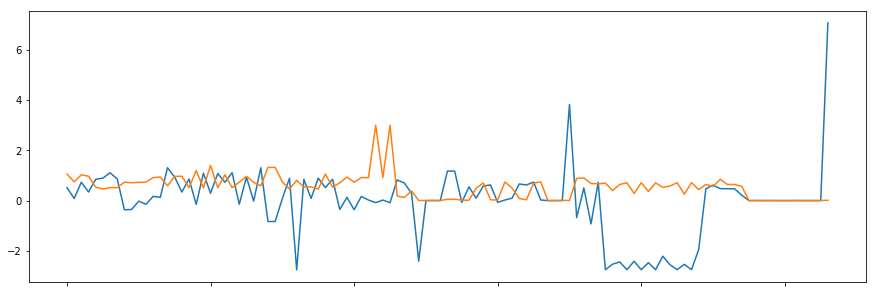

In [148]:
X_train.loc[y_train==1, :].skew(axis=0).plot()
(X_train.std(axis=0).abs()*6).plot()

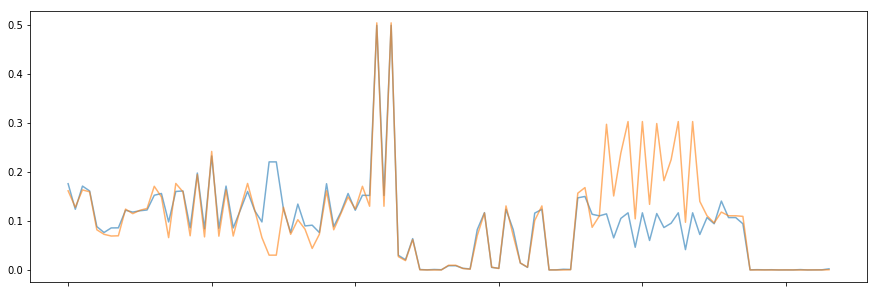

In [149]:
X_train.loc[y_train==0, :].std(axis=0).abs().plot(alpha=0.6)
X_train.loc[y_train==1, :].std(axis=0).abs().plot(alpha=0.6)

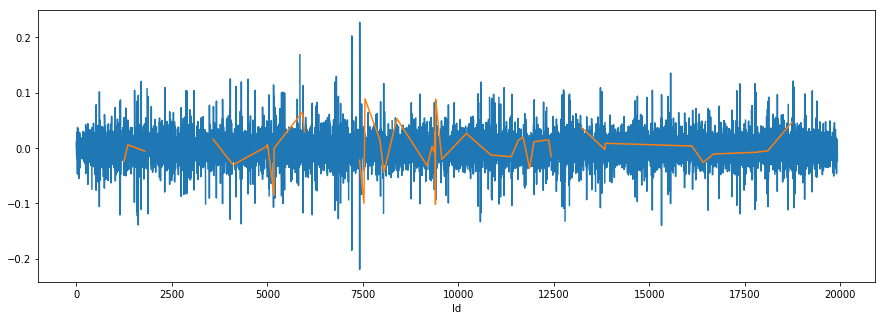

In [152]:
X_train.loc[y_train==0, :].diff(axis=0).mean(axis=1).plot()
X_train.loc[y_train==1, :].diff(axis=0).mean(axis=1).plot()

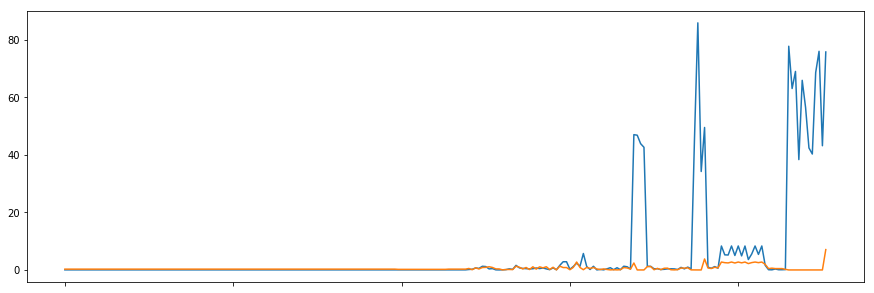

In [137]:
X_train.loc[y_train==0, :].skew(axis=0).abs().plot()
X_train.loc[y_train==1, :].skew(axis=0).abs().plot()

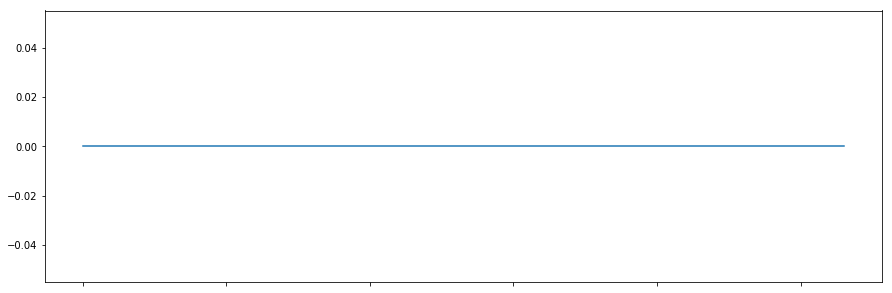

In [151]:
X_train.loc[y_train==1, :].skew(axis=0).isna().astype(int).plot()

In [143]:
train_n = pd.read_csv('../input/train_numeric.csv',nrows=10000)
train_n = train_n.set_index('Id')
X_train = train_n.loc[:, train_n.columns != 'Response']
y_train = train_n['Response']

In [145]:
vali_n = pd.read_csv('../input/train_numeric.csv',skiprows=range(1,10001),nrows=10000)
vali_n = vali_n.set_index('Id')
X_vali = vali_n.loc[:, vali_n.columns != 'Response']
y_vali = vali_n['Response']

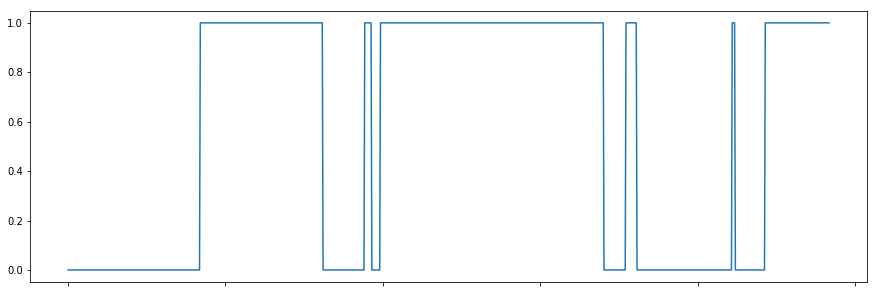

In [146]:
X_vali.loc[y_vali==1, :].skew(axis=0).isna().astype(int).plot()

Matthews correlation coefficient (MCC)を計算

In [22]:
test_d_indices = train_d_indices
test_n_indices = train_n_indices[:-1]

array([  0,   6,   9,  11,  13,  14,  27,  28,  34,  35,  36,  38,  41,
        47,  58,  81,  85, 113, 158, 258, 353, 383, 395, 685, 687, 726,
       727, 728, 729, 730, 732, 734, 735, 736, 737, 738, 742, 744, 758,
       770, 772, 777, 780, 782, 785, 789, 792, 794, 827, 828, 829, 832,
       833, 838, 839, 840, 842, 844, 851, 852, 855, 873, 884, 885, 886,
       969], dtype=int64)

# テストデータで予測する

In [21]:
test_n_indices = train_n_indices[:-1]
#test_d = pd.read_csv('../input/test_date.csv', usecols=test_d_indices)
test_n = pd.read_csv('../input/test_numeric.csv', usecols=test_n_indices)
#test_d = test_d.set_index('Id')
test_n = test_n.set_index('Id')
#test_x_feature = pd.concat([test_d, test_n], axis=1)
X_test = test_n

NameError: name 'train_n_indices' is not defined

In [272]:
preds = (clf.predict_proba(X_test)[:,1] > best_threshold).astype(np.int8)

In [273]:
sub = pd.read_csv("../input/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")

C:\Users\tmiya\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [27]:
#matlab用
x_feature.to_csv("X.csv")
y_feature.to_csv("y.csv")